# **Edit Graph State:**

Let's learn how to edit the state of a LangGraph while it is paused at a breakpoint, allowing a human-in-the-loop interaction for modifying graph state dynamically. Let’s go through the code step-by-step to understand how each part works, focusing on how to interact with and update the state of the graph.

In the last example we saw how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!

### **Set up Everything:**

In [1]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

In [3]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_flash: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract two numbers."""
    return a - b

def divide(a: int, b: int) -> float:
    """Divide two numbers."""
    return a / b

tools = [add, subtract, multiply, divide]

In [6]:
llm_with_tools = gemini_flash.bind_tools(tools)

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

breakpoints are also opportunities to modify the graph state.

Let's set up our agent with a breakpoint before the assistant node.

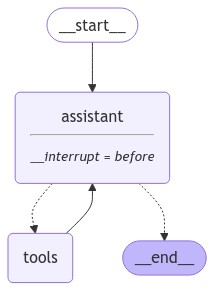

In [8]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition,)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

* **Interrupt Before Assistant Node:** The graph pauses before executing the assistant node, allowing us to modify the state at this point.

### **Starting the Graph Execution:**

In [9]:
# Thread
thread = {"configurable": {"thread_id": "1"}}

# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


* **Stream Execution Until Interruption:** Starts streaming in values mode. The graph runs node-by-node until it reaches the interruption point (assistant node).

### **Inspecting and Updating the State:**

In [11]:
state = graph.get_state(thread)
state.next

('assistant',)

### **Updating the State with New Input:**

In [12]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]}
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9540c-7a2d-6595-8001-5bf719863b42'}}

* **State Update:** Here, update_state is used to modify the graph state directly. A new message is added, which tells the assistant to perform a different calculation.

* **Reducer**: The add_messages reducer appends this message to the existing list of messages in the state.

If we want to over-write the existing message, we can supply the message id.

If we simply want to append to our list of messages, then we can pass a message without an id specified

### **Inspecting the Updated State:**

In [13]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


### **Continuing Execution After the Update:**

In [14]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
{'name': 'add', 'description': 'Add two numbers.', 'parameters': {'type_': 6, 'description': 'Add two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}}, 'required': ['a', 'b'], 'format_': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0'}}
{'name': 'subtract', 'description': 'Subtract two numbers.', 'parameters': {'type_': 6, 'description': 'Subtract two numbers.', 'properties': {'a': {'type_': 3, 'format_': '', 'description': '', 'nullable': False, 'enum': [], 'max_items': '0', 'min_items': '0', 'properties': {}, 'required': []}, 'b': {'type_': 3, 'format_': '', 'description'

* **Resume Execution:** Passing None as the initial input resumes the graph from where it paused. It continues executing the remaining nodes in the graph based on the updated state.

* **Output:** The assistant node processes the updated state, and the graph continues until it reaches another pause point or completes execution.